# Bike Rentals Prediction - Data Wrangling

Build a model that predicts number of bike rentals on a particular day, given the parameters.

First step of building predictive model is data preparation. In this notebook I will collect data from various sources, clean it and prepare in the correct format.

In [ ]:
import os
os.chdir('..')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import missingno as msno

import functions as f

## Feature engineering

In [2]:
df = pd.read_parquet('data/data_hourly.parquet')
df.sample(3)

C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,start_date,rentals_count,avg_duration,date,temperature,relative_temperature,wind,relative_humidity,pressure,clouds,rain,snow,thunder
32548,2014-02-13 17:00:00,0,NaN,2014-02-13,3.0,-2.0,320.0,0.81,993.0,cloudy,0.0,1.0,0.0
80121,2018-06-23 02:00:00,63,1008.031746,2018-06-23,19.0,19.0,20.0,0.94,1011.0,cloudy,0.0,0.0,0.0
11634,2011-12-31 19:00:00,85,1492.352941,NaT,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


### Convert hourly into daily data (with weather)

In [3]:
df = pd.concat([df, pd.get_dummies(df['clouds'], prefix='clouds')], axis=1)
df_daily = f.round_byTime(df, 'D', agg={'rentals_count': 'sum',
                             'temperature': ['max', 'min', 'mean'],
                             'relative_temperature': ['max', 'min', 'mean'],
                             'wind': ['max', 'min', 'mean'],
                             'pressure': ['max', 'min', 'mean'],
                             'rain': 'sum',
                             'snow': 'sum',
                             'thunder': 'sum',
                             'clouds_cloudy': 'sum',
                             'clouds_partly cloudy': 'sum',
                             'clouds_clear': 'sum'})

In [4]:
cols_level0 = df_daily.columns.droplevel()
cols_level1 = df_daily.columns.droplevel(1)
cols = []

for i in range(len(cols_level1)):
    cols.append(cols_level1[i] + '_' + cols_level0[i])
    
df_daily.columns = cols

### Add new features based on date

- season
- month
- weekday

In [5]:
df_daily['month'] = df_daily['start_date_'].dt.month
df_daily['weekday'] = df_daily['start_date_'].dt.weekday
df_daily['season'] = df_daily['month'].apply(f.meteo_season)

### Add information about holidays

In [6]:
us_holidays = holidays.US(state='DC')

In [7]:
df_daily['holiday'] = df_daily['start_date_'].apply(lambda x: us_holidays.get(x))

In [8]:
df_daily.head()

,start_date_,rentals_count_sum,temperature_max,temperature_min,temperature_mean,relative_temperature_max,relative_temperature_min,relative_temperature_mean,wind_max,wind_min,...,rain_sum,snow_sum,thunder_sum,clouds_cloudy_sum,clouds_partly cloudy_sum,clouds_clear_sum,month,weekday,season,holiday
0,2010-09-20,176,27.0,19.0,24.153846,26.0,19.0,23.307692,360.0,20.0,...,0.0,0.0,0.0,2,0,11,9,0,autumn,None
1,2010-09-21,269,27.0,14.0,20.375000,27.0,14.0,20.208333,360.0,0.0,...,0.0,0.0,0.0,2,0,22,9,1,autumn,None
2,2010-09-22,293,34.0,20.0,25.958333,36.0,20.0,26.791667,360.0,20.0,...,0.0,0.0,0.0,16,3,5,9,2,autumn,None
3,2010-09-23,370,33.0,22.0,27.041667,34.0,22.0,27.958333,360.0,0.0,...,0.0,0.0,0.0,13,6,5,9,3,autumn,None
4,2010-09-24,305,37.0,23.0,28.500000,37.0,24.0,29.333333,230.0,0.0,...,0.0,0.0,0.0,13,0,11,9,4,autumn,None


### Add website traffic data

Download & use data about online traffic from the tools available on the Internet (eg. Google Trends).

In [9]:
df_traffic = pd.read_parquet('data/predictors/traffic_daily.parquet')
df_trends = pd.read_parquet('data/predictors/trends_weekly.parquet')

In [10]:
df_daily['week_date'] = df_daily['start_date_'] - pd.to_timedelta(df_daily['start_date_'].dt.weekday + 1, unit='d')
df_daily['week_date'] = df_daily['week_date'].dt.strftime('%Y-%m-%d')

In [11]:
df_daily = df_daily.merge(df_trends, left_on='week_date', right_on='date', how='left')
df_daily = df_daily.merge(df_traffic, left_on='start_date_', right_on='date', how='left')

In [12]:
drop_cols = ['week_date', 'date_x', 'date_y']
df_daily.drop(drop_cols, axis=1, inplace=True)

Check which records contain missing values.

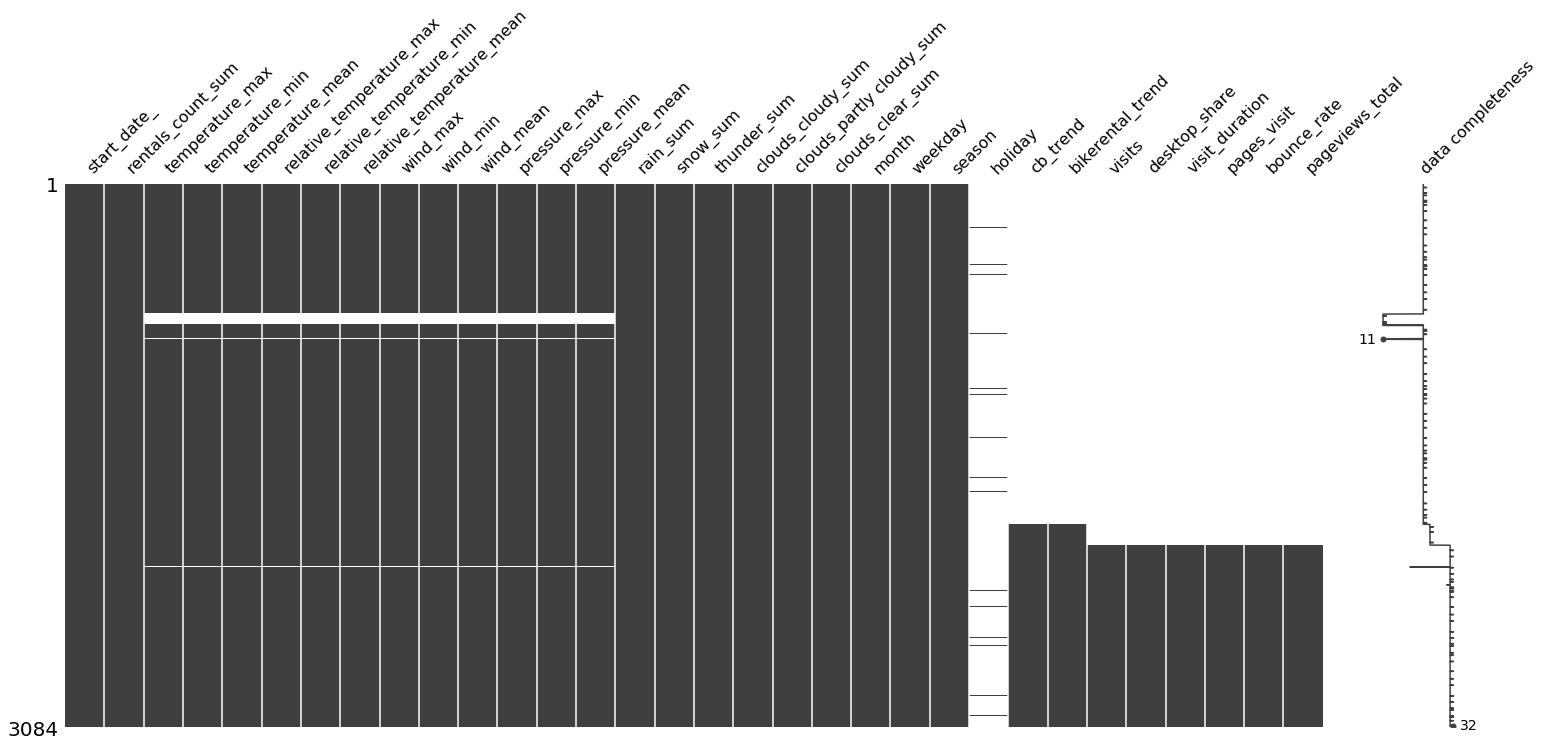

In [13]:
msno.matrix(df_daily, labels=list(df_daily.columns) )

Understand relations between different features.

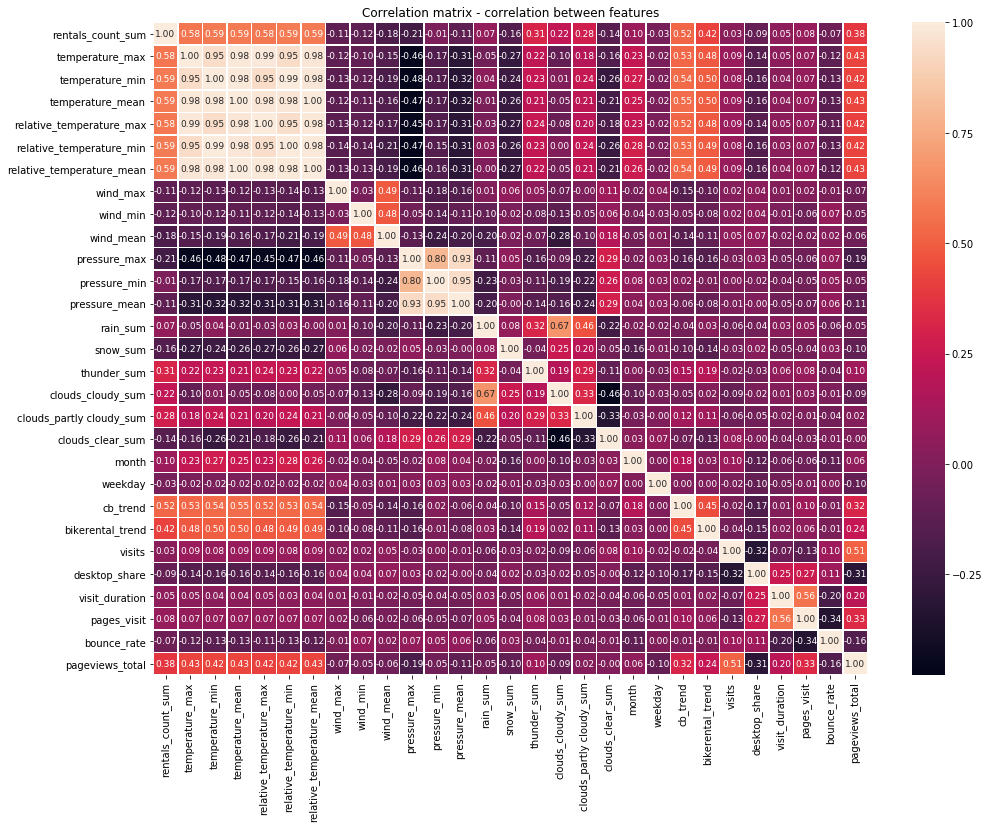

In [14]:
corr= df_daily.corr()
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr, annot=True, annot_kws={'size': 9}, linewidths=.5, fmt='.2f', ax=ax)
ax.set_title('Correlation matrix - correlation between features')
plt.show()

In [15]:
df_daily.to_parquet('data/data_predictors.parquet')

C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)
